# **Model Training**
This notebook focuses on model training.

---

## Accuracy-trained models

In [2]:
from ucimlrepo import fetch_ucirepo

cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

x = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

### 3. Naive Bayes

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

df = pd.concat([x, y], axis=1)

healthy_df = df[df['Diabetes_binary'] == 0]
diabetic_df = df[df['Diabetes_binary'] == 1]

healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                        'Income']

nb_model = GaussianNB()

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = []

for train_idx, test_idx in cv.split(X_balanced, y_balanced):
    # Split data into train and test folds
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

    nb_model.fit(X_train_scaled, y_train)
    score = nb_model.score(X_test_scaled, y_test)
    cv_scores.append(score)

cv_scores = np.array(cv_scores)
mean_accuracy = cv_scores.mean()
std_dev = cv_scores.std()
conf_interval_lower = mean_accuracy - std_dev
conf_interval_upper = mean_accuracy + std_dev

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Confidence Interval: [{conf_interval_lower:.2f}, {conf_interval_upper:.2f}]")

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced,
                                                    random_state=42)

# Normalization
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

nb_model.fit(X_train_scaled, y_train)
y_pred = nb_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Accuracy Scores: [0.71313412 0.71994441 0.72077832 0.71480195 0.71629135 0.72212955
 0.71670837 0.7206005  0.72421462 0.7117042 ]
Mean Accuracy: 0.72
Standard Deviation: 0.00
Confidence Interval: [0.71, 0.72]
Test Set Accuracy: 0.72
Confusion Matrix:
[[6528 2206]
 [1822 3833]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      8734
           1       0.63      0.68      0.66      5655

    accuracy                           0.72     14389
   macro avg       0.71      0.71      0.71     14389
weighted avg       0.72      0.72      0.72     14389



<br><br>
<br><br>
### 4. Bayesian network

  0%|          | 0/1000000 [00:00<?, ?it/s]

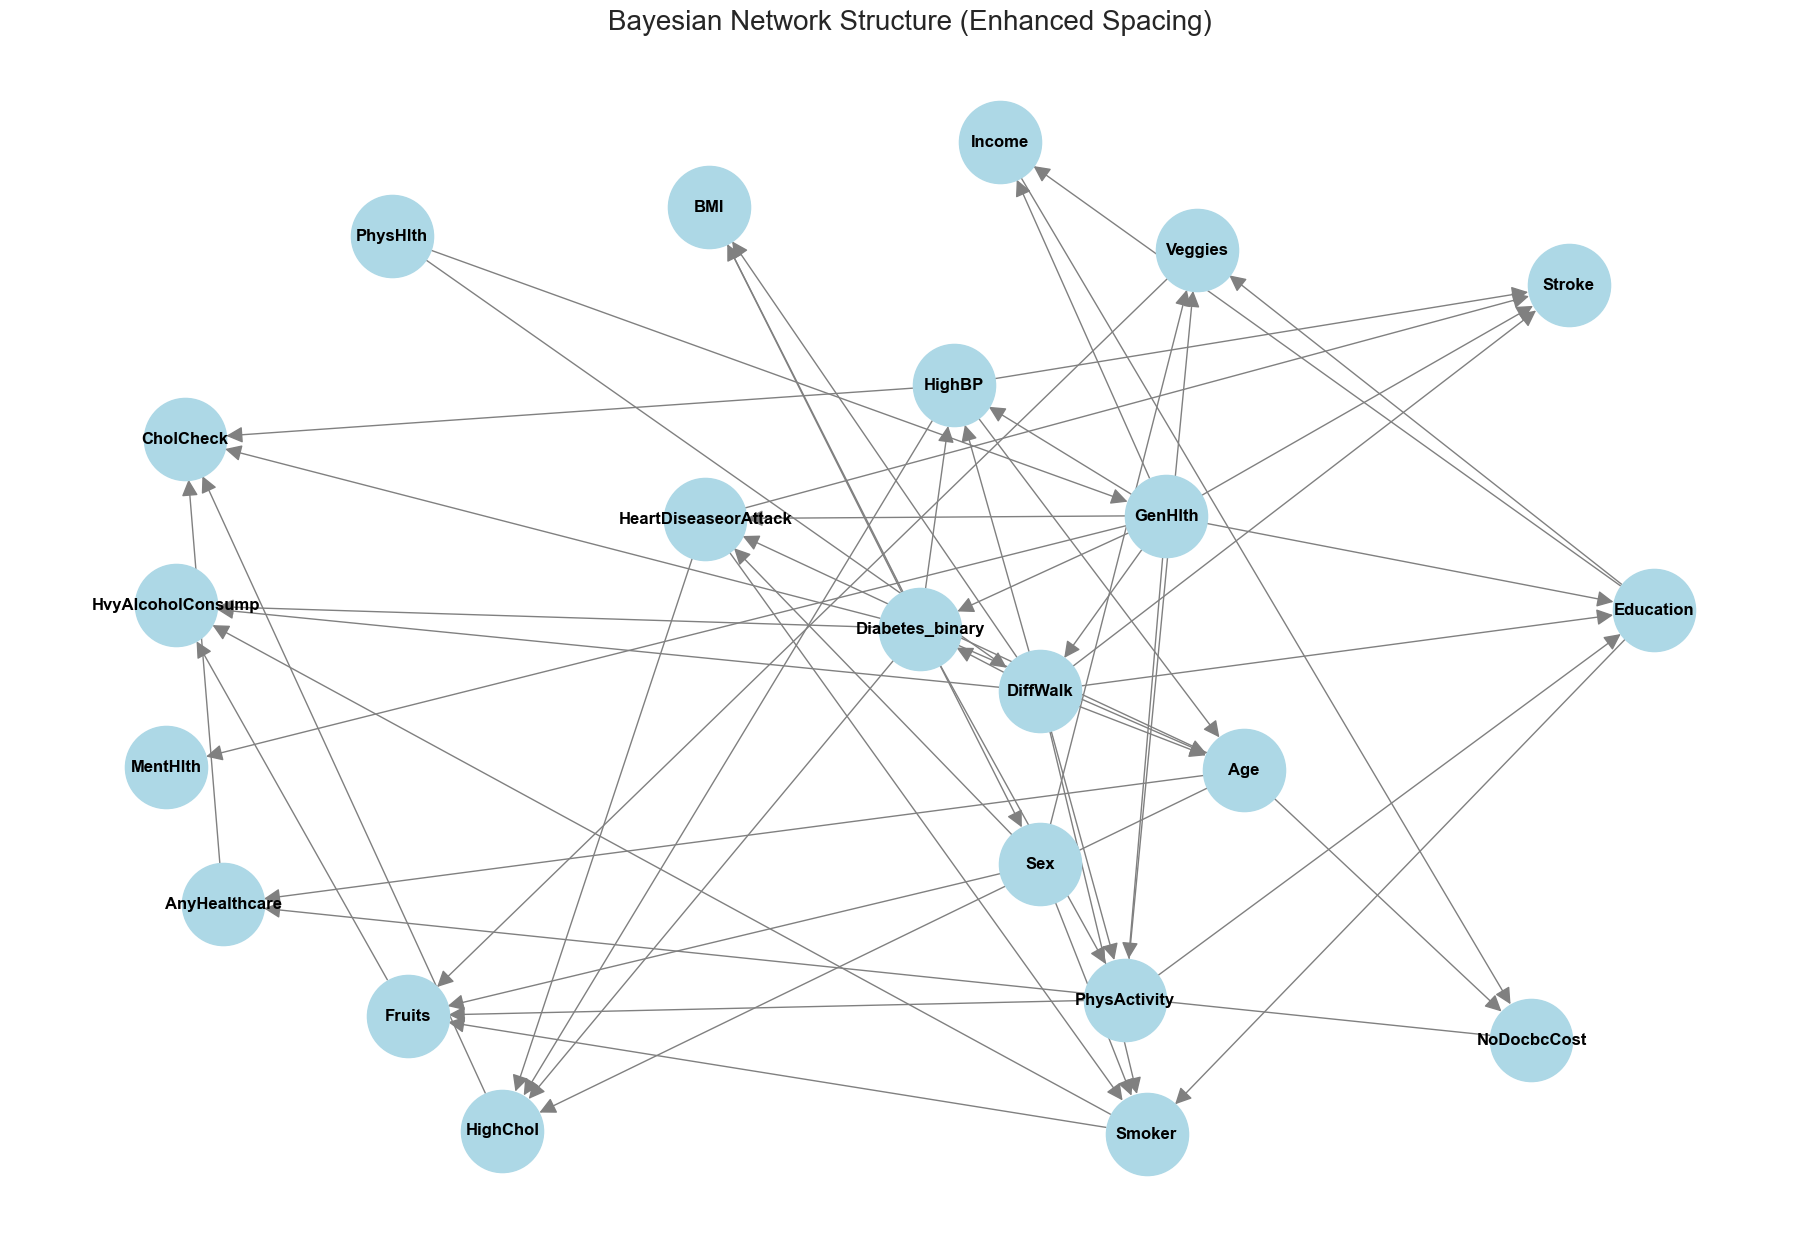

In [9]:
import pandas as pd  # Add this import for DataFrame operations
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
import matplotlib.pyplot as plt  # Corrected import for matplotlib
from sklearn.preprocessing import MinMaxScaler

# Ensure `x` and `y` are defined DataFrames before concatenation
# Example placeholders for `x` and `y`. Replace these with actual data.
# x = ...  # Feature DataFrame
# y = ...  # Target DataFrame (e.g., Diabetes_binary)

# Combine features and target into one DataFrame
data = pd.concat([x, y], axis=1)

# Split data into healthy and diabetic groups
healthy_df = data[data['Diabetes_binary'] == 0]
diabetic_df = data[data['Diabetes_binary'] == 1]

# Sampling subsets of healthy and diabetic groups
healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

# Combine the balanced sample
balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

# Separate features (X) and target (y)
X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

# Normalize specific columns
columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                        'Income']

scaler = MinMaxScaler()
X_balanced[columns_to_normalize] = scaler.fit_transform(X_balanced[columns_to_normalize])

# Combine normalized features with the target
normalized_data = pd.concat([X_balanced, y_balanced], axis=1)

# Hill Climb Search to find the best Bayesian Network structure
hc = HillClimbSearch(normalized_data)
best_model = hc.estimate(scoring_method=BicScore(normalized_data))

# Create and fit the Bayesian Network
bn_model = BayesianNetwork(best_model.edges())
bn_model.fit(normalized_data, estimator=MaximumLikelihoodEstimator)

# Visualize the Bayesian Network structure
graph = nx.DiGraph(bn_model.edges())
pos = nx.spring_layout(graph, k=1.5, seed=42)  # Layout for better spacing

plt.figure(figsize=(18, 12))
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=3500, 
    node_color="lightblue",
    font_size=12,  
    font_weight="bold",
    edge_color="gray",
    arrows=True,
    arrowsize=25
)

# Add a title and save the figure
plt.title("Bayesian Network Structure (Enhanced Spacing)", fontsize=20)
plt.savefig("bayesian_network_visualization_more_spaced.png", dpi=300)
plt.show()

<br><br>
<br><br>
### 5. Neural network (automatic)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Input
import keras_tuner as kt

from ucimlrepo import fetch_ucirepo 
  
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

df = pd.concat([X, y], axis=1)

healthy_df = df[df['Diabetes_binary'] == 0]
diabetic_df = df[df['Diabetes_binary'] == 1]

healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                        'Income']

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_balanced.shape[1],)))
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=16), activation='relu'))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16), activation='relu'))
        model.add(Dropout(rate=hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='binary_classification'
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in cv.split(X_balanced, y_balanced):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

    tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]

    scores = best_model.evaluate(X_test_scaled, y_test, verbose=0)
    cv_scores.append(scores[1])

cv_scores = np.array(cv_scores)
mean_accuracy = cv_scores.mean()
std_dev = cv_scores.std()
conf_interval_lower = mean_accuracy - std_dev
conf_interval_upper = mean_accuracy + std_dev

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Confidence Interval: [{conf_interval_lower:.2f}, {conf_interval_upper:.2f}]")

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

2025-01-06 16:04:59.843946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cross-Validation Accuracy Scores: [0.73314804 0.74621266 0.74621266 0.74371094 0.74228525 0.74047816
 0.74576038 0.74284124 0.74826247 0.73867112]
Mean Accuracy: 0.74
Standard Deviation: 0.00
Confidence Interval: [0.74, 0.75]
Epoch 1/50
1799/1799 [==============================] - 3s 1ms/step - loss: 0.5010 - accuracy: 0.7511
Epoch 2/50
1799/1799 [==============================] - 2s 1ms/step - loss: 0.4988 - accuracy: 0.7532
Epoch 3/50
1799/1799 [==============================] - 2s 994us/step - loss: 0.4973 - accuracy: 0.7540
Epoch 4/50
1799/1799 [==============================] - 2s 975us/step - loss: 0.4976 - accuracy: 0.7540
Epoch 5/50
1799/1799 [==============================] - 2s 1ms/step - loss: 0.4969 - accuracy: 0.7556
Epoch 6/50
1799/1799 [==============================] - 2s 1ms/step - loss: 0.4962 - accuracy: 0.7558
Epoch 7/50
1799/1799 [==============================] - 2s 996us/step - loss: 0.4974 - accuracy: 0.7560
Epoch 8/50
1799/1799 [==============================] 

<br><br>
<br><br>
### 6. Neural network (not automatic)

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_hidden_layers = 2  # 1 or 2

df = pd.concat([x, y], axis=1)

healthy_df = df[df['Diabetes_binary'] == 0]
diabetic_df = df[df['Diabetes_binary'] == 1]

healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                        'Income']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in cv.split(X_balanced, y_balanced):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.3))

    if num_hidden_layers == 2:
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

    scores = model.evaluate(X_test_scaled, y_test, verbose=0)
    cv_scores.append(scores[1])

cv_scores = np.array(cv_scores)
mean_accuracy = cv_scores.mean()
std_dev = cv_scores.std()
conf_interval_lower = mean_accuracy - std_dev
conf_interval_upper = mean_accuracy + std_dev

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Confidence Interval: [{conf_interval_lower:.2f}, {conf_interval_upper:.2f}]")

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))

if num_hidden_layers == 2:
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Accuracy Scores: [0.75066018 0.7449618  0.76066715 0.75149411 0.74534333 0.74589938
 0.75229359 0.75090355 0.75771475 0.74617738]
Mean Accuracy: 0.75
Standard Deviation: 0.01
Confidence Interval: [0.75, 0.76]
Epoch 1/50
1799/1799 [==============================] - 2s 674us/step - loss: 0.5236 - accuracy: 0.7299
Epoch 2/50
1799/1799 [==============================] - 1s 675us/step - loss: 0.5059 - accuracy: 0.7457
Epoch 3/50
1799/1799 [==============================] - 1s 684us/step - loss: 0.5021 - accuracy: 0.7476
Epoch 4/50
1799/1799 [==============================] - 1s 673us/step - loss: 0.5006 - accuracy: 0.7498
Epoch 5/50
1799/1799 [==============================] - 1s 678us/step - loss: 0.4999 - accuracy: 0.7492
Epoch 6/50
1799/1799 [==============================] - 1s 699us/step - loss: 0.4989 - accuracy: 0.7518
Epoch 7/50
1799/1799 [==============================] - 1s 669us/step - loss: 0.4977 - accuracy: 0.7518
Epoch 8/50
1799/1799 [========================

<br><br>
<br><br>
### 7. Deep learning

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout

df = pd.concat([x, y], axis=1)

healthy_df = df[df['Diabetes_binary'] == 0]
diabetic_df = df[df['Diabetes_binary'] == 1]

healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                        'Income']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in cv.split(X_balanced, y_balanced):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

    model = Sequential([
        Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

    scores = model.evaluate(X_test_scaled, y_test, verbose=0)
    cv_scores.append(scores[1])

cv_scores = np.array(cv_scores)
mean_accuracy = cv_scores.mean()
std_dev = cv_scores.std()
conf_interval_lower = mean_accuracy - std_dev
conf_interval_upper = mean_accuracy + std_dev

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Confidence Interval: [{conf_interval_lower:.2f}, {conf_interval_upper:.2f}]")

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Normalization
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Accuracy Scores: [0.74829745 0.7466296  0.75649756 0.7551077  0.74603838 0.74589938
 0.7496525  0.75159854 0.75618571 0.74756742]
Mean Accuracy: 0.75
Standard Deviation: 0.00
Confidence Interval: [0.75, 0.75]
Epoch 1/50
1799/1799 [==============================] - 2s 727us/step - loss: 0.5213 - accuracy: 0.7335
Epoch 2/50
1799/1799 [==============================] - 1s 694us/step - loss: 0.5062 - accuracy: 0.7461
Epoch 3/50
1799/1799 [==============================] - 1s 684us/step - loss: 0.5022 - accuracy: 0.7483
Epoch 4/50
1799/1799 [==============================] - 1s 664us/step - loss: 0.5007 - accuracy: 0.7500
Epoch 5/50
1799/1799 [==============================] - 1s 660us/step - loss: 0.5003 - accuracy: 0.7502
Epoch 6/50
1799/1799 [==============================] - 1s 678us/step - loss: 0.4996 - accuracy: 0.7501
Epoch 7/50
1799/1799 [==============================] - 1s 683us/step - loss: 0.4975 - accuracy: 0.7509
Epoch 8/50
1799/1799 [========================

<br><br>
<br><br>
### 8. SVM

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np

df = pd.concat([x, y], axis=1)

healthy_df = df[df['Diabetes_binary'] == 0]
diabetic_df = df[df['Diabetes_binary'] == 1]


healthy_sampled = healthy_df.sample(frac=0.2, random_state=42)  
diabetic_sampled = diabetic_df.sample(frac=0.8, random_state=42)

balanced_df = pd.concat([healthy_sampled, diabetic_sampled])

X_balanced = balanced_df.drop(columns=['Diabetes_binary'])
y_balanced = balanced_df['Diabetes_binary']

columns_to_normalize = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                        'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

svm_clf = LinearSVC(dual=False, random_state=42)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = []
y_pred_cv = []

for train_idx, test_idx in cv.split(X_balanced, y_balanced):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])    

    svm_clf.fit(X_train_scaled, y_train)
    score = svm_clf.score(X_test_scaled, y_test)
    cv_scores.append(score)
    
    y_pred_fold = svm_clf.predict(X_test_scaled)
    y_pred_cv.extend(y_pred_fold)

y_pred_cv = np.array(y_pred_cv)

cv_scores = np.array(cv_scores)
mean_accuracy = cv_scores.mean()
std_dev = cv_scores.std()
conf_interval_lower = mean_accuracy - std_dev
conf_interval_upper = mean_accuracy + std_dev

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Confidence Interval: [{conf_interval_lower:.2f}, {conf_interval_upper:.2f}]")


X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test_scaled[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])


svm_clf.fit(X_train_scaled, y_train)


y_test_pred = svm_clf.predict(X_test_scaled)


print("\nConfusion Matrix:")
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print(test_conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Cross-Validation Accuracy Scores: [0.74246004 0.74788047 0.75093815 0.74176511 0.74506533 0.73603003
 0.74450931 0.74770642 0.75437865 0.73797609]
Mean Accuracy: 0.74
Standard Deviation: 0.01
Confidence Interval: [0.74, 0.75]

Confusion Matrix:
[[7071 1663]
 [1968 3687]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      8734
           1       0.69      0.65      0.67      5655

    accuracy                           0.75     14389
   macro avg       0.74      0.73      0.73     14389
weighted avg       0.75      0.75      0.75     14389

